<a href="https://colab.research.google.com/github/Dahlia-Chehata/COVID-19-measures/blob/main/STAT_946_Final_Project_Seq2Seq_variations_updated_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Library imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import bz2
import _pickle as cPickle
import traceback
from functools import partial
from collections import defaultdict

!pip install "tqdm==4.43.0"
from tqdm.contrib.concurrent import process_map

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, Dataset, DataLoader

!pip install torch-lr-finder

from torch_lr_finder import LRFinder
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

!pip install plotly_express
import plotly_express as px
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

!pip install transformers
from transformers import BertTokenizer

import pathlib


     |████████████████████████████████| 61kB 4.0MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



     |████████████████████████████████| 2.1MB 7.8MB/s 
     |████████████████████████████████| 3.3MB 55.1MB/s 
     |████████████████████████████████| 870kB 52.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=4dbd017d17ee946a0fe6934366e83a9e26aea60c360b7f1d5adbf35df5b0f50d
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


# **2. Data Loading and Cleaning**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = '/content/drive/MyDrive/STAT946: Project/'

In [ ]:
regulations = pd.read_excel(dir + 'data/acaps_covid19_government_measures_dataset_0.xlsx', sheet_name = 'Dataset')
cases = pd.read_csv(dir + 'data/archive/covid_19_data_updated.csv')

In [ ]:
regulations.head()

ID  ISO  ... ENTRY_DATE Alternative source
0  4245  AFG  ... 2020-04-07                NaN
1  4246  AFG  ... 2020-04-07                NaN
2  4247  AFG  ... 2020-04-07                NaN
3  4248  AFG  ... 2020-04-07                NaN
4    23  AFG  ... 2020-03-14                NaN

[5 rows x 18 columns]

In [ ]:
cases.head(200)

SNo       Country/Region  Confirmed  Deaths  Recovered ObservationDate
0      0          Afghanistan      51526    2191      41727      01-01-2021
1      1              Albania      58316    1181      33634      01-01-2021
2      2              Algeria      99897    2762      67395      01-01-2021
3      3              Andorra       8117      84       7463      01-01-2021
4      4               Angola      17568     405      11146      01-01-2021
..   ...                  ...        ...     ...        ...             ...
195  195               Angola      17608     407      11189      01-02-2021
196  196  Antigua and Barbuda        159       5        148      01-02-2021
197  197            Argentina    1634834   43375    1447092      01-02-2021
198  198              Armenia     159798    2836     143640      01-02-2021
199  199            Australia      28484     909      22581      01-02-2021

[200 rows x 6 columns]

In [ ]:
print(regulations.shape)
print(cases.shape)

(23923, 18)
(76635, 6)


In [ ]:
np.unique(cases['Country/Region'])

array([' Azerbaijan', 'Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahamas, The',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cruise Ship', 'Cuba', 'Curacao',
       'Cyprus', 'Czech Republic', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'East Timor', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Est

In [ ]:
np.unique(regulations['COUNTRY'])

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'CAR', 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', "CÃ´te d'Ivoire", 'DPRK', 'DRC',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
       'Honduras', 'Hong Kong', 'Hunga

In [ ]:
np.setdiff1d(cases['Country/Region'], regulations['COUNTRY']) # unique values in the cases but not in the regulations

array([' Azerbaijan', 'Andorra', 'Aruba', 'Bahamas, The', 'Burma',
       'Cabo Verde', 'Cayman Islands', 'Central African Republic',
       'Channel Islands', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       "Cote d'Ivoire", 'Cruise Ship', 'Curacao', 'Czechia',
       'Diamond Princess', 'East Timor', 'Faroe Islands', 'French Guiana',
       'Gambia, The', 'Gibraltar', 'Greenland', 'Guadeloupe', 'Guam',
       'Guernsey', 'Holy See', 'Hong Kong SAR',
       'Iran (Islamic Republic of)', 'Ivory Coast', 'Jersey',
       'Korea, South', 'Kosovo', 'MS Zaandam', 'Macao SAR', 'Macau',
       'Mainland China', 'Martinique', 'Mayotte', 'Monaco',
       'North Ireland', 'North Macedonia', 'Others', 'Puerto Rico',
       'Republic of Ireland', 'Republic of Korea', 'Republic of Moldova',
       'Republic of the Congo', 'Reunion', 'Russian Federation',
       'Saint Barthelemy', 'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Martin', 'Saint Vincent and the Grenadines', 'South Korea',
    

We want to join on Country and Date, but we can see that there are some naming differences between the countries in the `cases` dataset and the `regulations` dataset.

In [ ]:
np.setdiff1d(regulations['COUNTRY'], cases['Country/Region'])  # unique values in the regulations but not in the cases

array(['CAR', 'Congo', "CÃ´te d'Ivoire", 'DPRK', 'DRC', 'Kiribati',
       'Korea, Republic of', 'Macedonia', 'Myanmar', 'Nauru', 'Palau',
       'St. Kitts and Nevis', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Timor Leste', 'Tonga',
       'Turkmenistan', 'Tuvalu', 'United States'], dtype=object)

In [ ]:
old = ['Mainland China', 
       'US', 
       'UK', 
       'Saint Vincent and the Grenadines', 
       'Saint Lucia', 
       'Saint Kitts and Nevis',
       'North Macedonia',
       'Congo (Brazzaville)', 
       'Congo (Kinshasa)',
       'Republic of Ireland',
       'North Ireland',
       'West Bank and Gaza',
       'occupied Palestinian territory',
       'Guernsey',
       'Jersey',
       'Channel Islands',
       'Cayman Islands',
       'Diamond Princess',
       'Aruba',
       'Curacao',
       'Saint Martin',
       'St. Martin',
       "('St. Martin',)",
       'Guadeloupe',
       'Martinique',
       'Mayotte',
       'Reunion',
       'Saint Barthelemy',
       'Republic of the Congo',
       'East Timor',
       'Greenland',
       'Faroe Islands',
       'French Guiana',
       'Gibraltar',
       'Gambia, The',
       'The Gambia',
       'Cabo Verde',
       'Guam',
       'Puerto Rico',
       'Macau',
       'MS Zaandam',
       'The Bahamas',
       'Bahamas, The',
       ' Azerbaijan',
       'Vatican City',
       'Burma',
       "Cote d'Ivoire",
       'Korea, South',
       'Republic of Korea',
       'Iran (Islamic Republic of)',
       'Taipei and environs',
       'Taiwan*',
       'Hong Kong SAR',
       'Russian Federation',
       'Czechia',
       'Macao SAR',
       'Viet Nam',
       'Republic of Moldova',
       ]

new = ['China',
       'United States',
       'United Kingdom',
       'St. Vincent and the Grenadines',
       'St. Lucia',
       'St. Kitts and Nevis',
       'Macedonia',
       'Congo',
       'Congo',
       'Ireland',
       'Ireland',
       'Palestine',
       'Palestine',
       'United Kingdom',
       'United Kingdom',
       'United Kingdom',
       'United Kingdom',
       'United Kingdom',
       'Netherlands',
       'Netherlands',
       'France',
       'France',
       'France',
       'France',
       'France',
       'France',
       'France',
       'France',
       'Congo',
       'Timor-Leste',
       'Denmark',
       'Denmark',
       'Denmark',
       'Denmark',
       'Gambia',
       'Gambia',
       'Cape Verde',
       'United States',
       'United States',
       'China',
       'Netherlands',
       'Bahamas',
       'Bahamas',
       'Azerbaijan',
       'Holy See',
       'Myanmar',
       'Ivory Coast',
       'South Korea',
       'South Korea',
       'Iran',
       'Taiwan',
       'Taiwan',
       'Hong Kong',
       'Russia',
       'Czech Republic',
       'China',
       'Vietnam',
       'Moldova',
       ]
cases = cases.replace(old, new)

In [ ]:
old = ['Korea, Republic of',
       'DPRK',
       'DRC',
       'CAR',
       "CÃ´te d'Ivoire",
       'Timor Leste',
       ]

new = ['South Korea',
       'North Korea',
       'Congo',
       'Central African Republic',
       'Ivory Coast',
       'Timor-Leste'
       ]
regulations = regulations.replace(old, new)

Another issue is that the maximum granularity of the `regulations` dataset is `COUNTRY`, but the `cases` dataset is given by `Province/State`. One solution is to sum all cases by `Province/State` to the level of `Country/Region`.

In [ ]:
cases_by_country = cases.groupby(['Country/Region', 'ObservationDate']).sum(['Confirmed', 'Deaths', 'Recovered']).drop(['SNo'], axis = 1)
cases_by_country.reset_index(level=['Country/Region', 'ObservationDate'], inplace=True)

cases_by_country.head()

Country/Region ObservationDate  Confirmed  Deaths  Recovered
0    Afghanistan      01-01-2021      51526    2191      41727
1    Afghanistan      01-02-2021      51526    2191      41727
2    Afghanistan      01-03-2021      51526    2191      41727
3    Afghanistan      01-04-2021      53011    2237      42530
4    Afghanistan      01-05-2021      53105    2244      42666

In [ ]:
regulations[(regulations['DATE_IMPLEMENTED'] == pd.to_datetime('2020-02-24')) & (regulations['COUNTRY'] == 'Afghanistan')]

ID  ISO  ... ENTRY_DATE Alternative source
19     6  AFG  ... 2020-03-14                NaN
20  4262  AFG  ... 2020-04-07                NaN
21  4260  AFG  ... 2020-04-07                NaN
22  4261  AFG  ... 2020-04-07                NaN
23  4259  AFG  ... 2020-04-07                NaN

[5 rows x 18 columns]

We have that multiple measures were implemented on the same date. Therefore we should concatenate them into a single string.

In [ ]:
dropped_comments = regulations.dropna(subset = ['COMMENTS'])
dropped_categories = regulations.dropna(subset = ['CATEGORY'])

measures = regulations.groupby(['COUNTRY', 'DATE_IMPLEMENTED'])['MEASURE'].apply('. '.join).reset_index()
comments = dropped_comments.groupby(['COUNTRY', 'DATE_IMPLEMENTED'])['COMMENTS'].apply('. '.join).reset_index()
category = dropped_categories.groupby(['COUNTRY', 'DATE_IMPLEMENTED'])['CATEGORY'].apply('. '.join).reset_index()

measures_and_comments = pd.merge(measures, comments, how = 'left')
all = pd.merge(measures_and_comments, category, how = 'left')
all.head()

COUNTRY  ...                                        CATEGORY
0  Afghanistan  ...                          Public health measures
1  Afghanistan  ...                          Public health measures
2  Afghanistan  ...   Movement restrictions. Public health measures
3  Afghanistan  ...                           Movement restrictions
4  Afghanistan  ...  Public health measures. Public health measures

[5 rows x 5 columns]

If we want to merge the datasets by date, we need to change the format of the `ObservationDate` series in `cases` to a `datetime` type.

In [ ]:
cases_by_country['ObservationDate'] = pd.to_datetime(cases_by_country['ObservationDate'])

In [ ]:
cases_by_country.head()

Country/Region ObservationDate  Confirmed  Deaths  Recovered
0    Afghanistan      2021-01-01      51526    2191      41727
1    Afghanistan      2021-01-02      51526    2191      41727
2    Afghanistan      2021-01-03      51526    2191      41727
3    Afghanistan      2021-01-04      53011    2237      42530
4    Afghanistan      2021-01-05      53105    2244      42666

In [ ]:
data = pd.merge(all, cases_by_country, left_on = ['COUNTRY', 'DATE_IMPLEMENTED'], right_on = ['Country/Region', 'ObservationDate'], how = 'right')

Assumption to be made is that the last regulation is in place until the next regulation is in place. Therefore we fill missing values using forward fill.

In [ ]:
data = data.sort_values(['Country/Region', 'ObservationDate']).fillna(method = 'ffill')
data = data.groupby('Country/Region').transform(lambda v: v.ffill())
data.head()

COUNTRY DATE_IMPLEMENTED  ... Deaths Recovered
54  Afghanistan       2020-02-24  ...      0         0
56  Afghanistan       2020-02-24  ...      0         0
58  Afghanistan       2020-02-24  ...      0         0
60  Afghanistan       2020-02-24  ...      0         0
62  Afghanistan       2020-02-24  ...      0         0

[5 rows x 9 columns]

We can drop the duplicate columns:

In [ ]:
data = data.drop(labels = ['DATE_IMPLEMENTED'], axis = 1).dropna(subset = ['MEASURE'])
data = data.sort_values(['COUNTRY', 'ObservationDate'])
data.head(50)

COUNTRY  ... Recovered
54   Afghanistan  ...         0
56   Afghanistan  ...         0
58   Afghanistan  ...         0
60   Afghanistan  ...         0
62   Afghanistan  ...         0
64   Afghanistan  ...         0
65   Afghanistan  ...         0
67   Afghanistan  ...         0
69   Afghanistan  ...         0
71   Afghanistan  ...         0
73   Afghanistan  ...         0
75   Afghanistan  ...         0
77   Afghanistan  ...         0
79   Afghanistan  ...         0
81   Afghanistan  ...         0
83   Afghanistan  ...         0
85   Afghanistan  ...         0
87   Afghanistan  ...         0
89   Afghanistan  ...         0
91   Afghanistan  ...         0
93   Afghanistan  ...         0
95   Afghanistan  ...         1
97   Afghanistan  ...         1
99   Afghanistan  ...         1
101  Afghanistan  ...         1
103  Afghanistan  ...         1
105  Afghanistan  ...         1
107  Afghanistan  ...         1
109  Afghanistan  ...         1
111  Afghanistan  ...         1
113  Afghanistan  ...         2
115  Afghanistan  ...         2
117  Afghanistan  ...         2
119  Afghanistan  ...         2
121  Afghanistan  ...         2
123  Afghanistan  ...         2
125  Afghanistan  ...         5
127  Afghanistan  ...         5
129  Afghanistan  ...        10
131  Afghanistan  ...        10
133  Afghanistan  ...        10
135  Afghanistan  ...        15
137  Afghanistan  ...        18
139  Afghanistan  ...        18
141  Afghanistan  ...        29
143  Afghanistan  ...        32
145  Afghanistan  ...        32
147  Afghanistan  ...        32
149  Afghanistan  ...        32
150  Afghanistan  ...        32

[50 rows x 8 columns]

In [ ]:
np.unique(data['COUNTRY'])

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
       'Honduras', 'Hungary', 'Iceland', 'India', 

This is the final sequential dataset.

In [ ]:
data.to_csv(dir + 'new_cleaned_data.csv', index=False)

# **3. Feature Engineering**

In [53]:
# load cleaned data
data = pd.read_csv (dir + 'new_cleaned_data.csv')
data.Confirmed.describe()

count    7.528800e+04
mean     2.500199e+05
std      1.366366e+06
min      0.000000e+00
25%      7.650000e+02
50%      8.321000e+03
75%      8.545900e+04
max      3.119787e+07
Name: Confirmed, dtype: float64

In [54]:
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'], errors='coerce')
print(data['ObservationDate'].min(), data['ObservationDate'].max())

2020-01-22 00:00:00 2021-04-11 00:00:00


In [55]:
data['dayofweek'] = data['ObservationDate'].dt.dayofweek
data['month'] = data['ObservationDate'].dt.month
data['year'] = data['ObservationDate'].dt.year
data['day'] = data['ObservationDate'].dt.day

In [56]:
data['year'].min(), data['year'].max()

(2020, 2021)

In [57]:
data['year_mod'] = (data['year'] - data['year'].min()) / (data['year'].max() - data['year'].min())

In [58]:
def sin_transform(values):
    return np.sin(2*np.pi*values/len(set(values)))

def cos_transform(values):
    return np.cos(2*np.pi*values/len(set(values)))

In [59]:
data['dayofweek_sin'] = sin_transform(data['dayofweek'])
data['dayofweek_cos'] = cos_transform(data['dayofweek'])
data['month_sin'] = sin_transform(data['month'])
data['month_cos'] = cos_transform(data['month'])
data['day_sin'] = sin_transform(data['day'])
data['day_cos'] = cos_transform(data['day'])

In [60]:
data = data.sort_values(['COUNTRY', 'ObservationDate'])

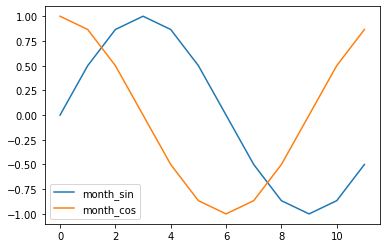

In [61]:
plt.plot(sin_transform(np.arange(0,12)), label='month_sin')
plt.plot(cos_transform(np.arange(0,12)), label='month_cos')
plt.legend()

In [62]:
data.head()

COUNTRY  ...   day_cos
0  Afghanistan  ...  0.151428
1  Afghanistan  ...  0.347305
2  Afghanistan  ...  0.528964
3  Afghanistan  ...  0.688967
4  Afghanistan  ...  0.820763

[5 rows x 19 columns]

In [63]:
def plot_line(acf):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(acf))), y=acf,mode='lines',name='acf'))
    fig.show()

In [64]:
# Plot the data of a sample country
item_data = data[data['COUNTRY'] == 'Afghanistan'].sort_values('ObservationDate')
print(item_data)

item_ac = acf(item_data['Confirmed'], nlags=366, fft=True)
print('Lag value: ',len(item_ac))

px.line(item_data, x='ObservationDate', y='Confirmed', title='Afghanistan Confirmed cases with 14 days lag')
plot_line(item_ac)

         COUNTRY  ...   day_cos
0    Afghanistan  ...  0.151428
1    Afghanistan  ...  0.347305
2    Afghanistan  ...  0.528964
3    Afghanistan  ...  0.688967
4    Afghanistan  ...  0.820763
..           ...  ...       ...
408  Afghanistan  ...  0.151428
409  Afghanistan  ... -0.050649
410  Afghanistan  ... -0.250653
411  Afghanistan  ... -0.440394
412  Afghanistan  ... -0.612106

[413 rows x 19 columns]
Lag value:  367


In [65]:
avg_data = data[['ObservationDate', 'Confirmed']].groupby('ObservationDate').mean()
print(avg_data.head)

avg_ac = acf(avg_data['Confirmed'], nlags=len(avg_data), fft=True)
print('Average number of cases over the total time period')
plot_line(avg_ac)

<bound method NDFrame.head of                      Confirmed
ObservationDate               
2020-01-22           79.571429
2020-01-23           73.133333
2020-01-24           94.100000
2020-01-25          110.538462
2020-01-26          151.285714
...                        ...
2021-04-07       704251.243386
2021-04-08       708694.894180
2021-04-09       712652.804233
2021-04-10       716168.703704
2021-04-11       719823.407407

[446 rows x 1 columns]>
Average number of cases over the total time period


In [66]:
important_lags = np.argsort(-avg_ac)[:100]
important_lags

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [67]:
len(data['COUNTRY'].unique())

183

In [68]:
sample_data = data[data['COUNTRY'].isin(pd.Series(data['COUNTRY'].unique()).sample(10))]

In [69]:
px.line(sample_data, x='ObservationDate', y='Confirmed', color='COUNTRY', title='Covid19 Confirmed Cases per Country')

compute yearly autocorrelation for each timeseries

In [70]:
def get_yearly_autocorr(data):
    ac = acf(data, nlags=366, fft=True)
    n = len(ac)
    # print(n)
    if n < 367:
      return (0.5 * ac[n-2]) + (0.25 * ac[n-3]) + (0.25 * ac[n-1]), False
    return (0.5 * ac[365]) + (0.25 * ac[364]) + (0.25 * ac[366]), True

In [71]:
scale_map = {}
scaled_data = pd.DataFrame()
removal_list = []

for country_id, item_data in tqdm(data.groupby('COUNTRY', as_index=False)):
    
    indexes = data.index[data['COUNTRY'] == country_id].tolist()

    sidata = data.loc[data['COUNTRY'] == country_id, 'Confirmed']
    sidata2 = data.loc[data['COUNTRY'] == country_id, 'Deaths']
    sidata3 = data.loc[data['COUNTRY'] == country_id, 'Recovered']

    mu = sidata.mean()
    sigma = sidata.std()
    yearly_autocorr, keep = get_yearly_autocorr(sidata)

    mu2 = sidata2.mean()
    sigma2 = sidata2.std()

    mu3 = sidata3.mean()
    sigma3 = sidata3.std()

    if not keep:
      #print(indexes)
      removal_list = np.concatenate((removal_list, indexes), axis=0)
    else:
      item_data.loc[:,'Confirmed'] = (item_data['Confirmed'] - mu) / sigma
      if mu2 !=0  and sigma2 != 0:
        item_data.loc[:,'Deaths'] = (item_data['Deaths'] - mu2) / sigma2
      item_data.loc[:,'Recovered'] = (item_data['Recovered'] - mu3) / sigma3
      
      scale_map[country_id] = {'mu': mu, 'sigma': sigma}
      item_data['mean_cases'] = mu
      item_data['yearly_corr'] = yearly_autocorr
      scaled_data = pd.concat([scaled_data, item_data], ignore_index=True)

print(removal_list)
print(scaled_data.isnull().values.sum())


[14980. 14981. 14982. ... 73302. 73303. 73304.]
0


In [ ]:
print(data.shape)
print(len(np.unique(data['COUNTRY'])))

indexes_to_keep = set(range(data.shape[0])) - set(removal_list)
data = data.take(list(indexes_to_keep))

print(data.shape)
print(len(np.unique(data['COUNTRY'])))

(75288, 19)
183
(73384, 19)
176


In [ ]:
scaled_data['yearly_corr'] = ((scaled_data['yearly_corr'] - scaled_data['yearly_corr'].mean()) / scaled_data['yearly_corr'].std())

In [ ]:
scaled_data['yearly_corr']

0       -0.717784
1       -0.717784
2       -0.717784
3       -0.717784
4       -0.717784
           ...   
73379    1.342781
73380    1.342781
73381    1.342781
73382    1.342781
73383    1.342781
Name: yearly_corr, Length: 73384, dtype: float64

In [ ]:
scaled_data['mean_cases'] = (scaled_data['mean_cases'] - scaled_data['mean_cases'].mean()) / scaled_data['mean_cases'].std()

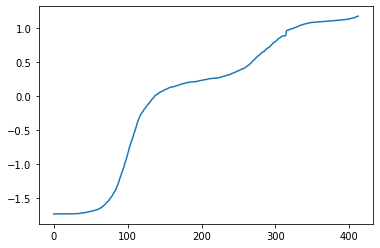

In [ ]:
scaled_data.loc[scaled_data['COUNTRY'] == 'Afghanistan', 'Confirmed'].plot()

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
scaled_data.drop(['ObservationDate','day', 'month', 'year', 'dayofweek', 'mean_cases'], axis=1).head()

COUNTRY  ... yearly_corr
0  Afghanistan  ...   -0.717784
1  Afghanistan  ...   -0.717784
2  Afghanistan  ...   -0.717784
3  Afghanistan  ...   -0.717784
4  Afghanistan  ...   -0.717784

[5 rows x 15 columns]

In [ ]:
scaled_data = reduce_mem_usage(scaled_data)

Mem. usage decreased to  4.83 Mb (58.9% reduction)


In [ ]:
scaled_data.head()

COUNTRY  ... yearly_corr
0  Afghanistan  ...   -0.717773
1  Afghanistan  ...   -0.717773
2  Afghanistan  ...   -0.717773
3  Afghanistan  ...   -0.717773
4  Afghanistan  ...   -0.717773

[5 rows x 21 columns]

In [ ]:
scaled_data.to_pickle(dir + 'new_processed_data_stdscaler2.pkl')

# **4. Data Preprocessing**

## **4.1. Embeddings**

### **4.1.1. Concatenated Measures' Embeddings**



In [ ]:
# Load the preprocessed data file 
# data = pd.read_csv (dir + 'new_cleaned_data.csv')
# sentences = data['MEASURE'].tolist()
# data['MEASURE'].shape

In [ ]:
!pip install 'tensorflow==1.15.0'
%tensorflow_version 1.x

!pip install bert-serving-client
!pip install -U bert-serving-server[http]

!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
!nohup bert-serving-start -max_seq_len 100 -model_dir=./uncased_L-12_H-768_A-12 > out.file 2>&1 &

!ls  # you should see uncased_something_.zip

from bert_serving.client import BertClient
bc = BertClient()
embedded_text = bc.encode(sentences)

with open(dir + 'new_concat_embedding.txt', 'wb') as fp:   #Pickling
  pickle.dump(embedded_text, fp) 


     |████████████████████████████████| 412.3MB 34kB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 512kB 17.9MB/s 
     |████████████████████████████████| 3.8MB 28.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=e2852fb5c01ae59b398c9be229a721a759c26d58b958a18df61026337a13482e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

TensorFlow 1.x selected.
     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 358kB 17.8MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=990bcebd9ecde23022735edb471d2217d8573d16b3e84051c386b71c876164d6
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
--2021-04-15 01:07:10--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 142.250.107.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   161MB/s    in 2.4s    

2021-04-15 01:07:12 (161 MB/s) - ‘uncased_L-12_H-76

In [ ]:
# Load embedding file
infile = open(dir + 'new_concat_embedding.txt','rb')
embeddings = pickle.load(infile)

In [ ]:
embeddings.shape

(75288, 768)

In [ ]:
embeddings = np.delete(embeddings, removal_list.astype(int), axis=0)

In [ ]:
embeddings.shape

(73384, 768)

In [ ]:
with open(dir + 'new_concat_embedding2.txt', 'wb') as fp:   #Pickling
  pickle.dump(embeddings, fp)

In [ ]:
infile = open(dir + 'new_concat_embedding2.txt','rb')
embeddings = pickle.load(infile)

### **4.1.2. Other embedding types**



1.   BioBERT Embeddings
2.   Mean Aggregated Embeddings
3.   Autoencoder-based Embeddings

For further details: please refer to the notebook:
https://colab.research.google.com/drive/1ZuZbwU0HsyufsuqowKGZU-Zw2r2r-87R?usp=sharing 



## **4.2. Sequence Generation**
This subsection needs to be run locally due to Colab RAM limitations.

In [ ]:
# Multiprocessing

def _apply_df(args):
    df, func, key_column = args
    result = df.groupby(key_column).progress_apply(func)
    return result

def almost_equal_split(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out


def mp_apply(df, func, key_column):
    workers = 8
    key_splits = almost_equal_split(df[key_column].unique(), workers) # split by the number of COUNTRY
    split_dfs = [df[df[key_column].isin(key_list)] for key_list in key_splits]
    result = process_map(_apply_df, [(d, func, key_column) for d in split_dfs], max_workers=workers)
    return pd.concat(result)

In [ ]:
# split a multivariate sequence into samples
def split_sequences(group_data, 
                    n_steps_in, 
                    n_steps_out, 
                    x_cols, 
                    y_cols, 
                    additional_columns, 
                    step=1, 
                    lag_fns=[]):
  
    X, y = list(), list()
    additional_col_map = defaultdict(list)
    group_data = group_data.sort_values('ObservationDate')
    
    for i, lag_fn in enumerate(lag_fns):
        group_data[f'lag_{i}'] = lag_fn(group_data[y_cols[0]])
    
    steps = list(range(0, len(group_data), step))
    if step != 1 and steps[-1] != (len(group_data) - 1):
        steps.append((len(group_data) - 1))
    
    for i in steps:
        # find the end of this pattern
        in_end_idx = i + n_steps_in
        out_end_idx = in_end_idx + n_steps_out
        # check if we are beyond the dataset
        if out_end_idx > len(group_data):
            break
        # gather input and output parts of the pattern
        if len(x_cols) == 1:
            x_cols = x_cols[0]
        seq_x = group_data.iloc[i:in_end_idx, :][x_cols].values
        seq_y = group_data.iloc[in_end_idx:out_end_idx, :][y_cols + [f'lag_{i}' for i in range(len(lag_fns))]].values
    
        for col in additional_columns:
            additional_col_map[col].append(group_data.iloc[in_end_idx][col])
        
        X.append(seq_x)
        y.append(seq_y)
       
    
    additional_column_items = sorted(additional_col_map.items(), key=lambda x: x[0])
    return (np.array(X), np.array(y), *[i[1] for i in additional_column_items])

In [ ]:
def sequence_builder(data, 
                     n_steps_in,
                     n_steps_out, 
                     key_column, 
                     x_cols, 
                     y_col, 
                     y_cols, 
                     additional_columns, 
                     diff=False, 
                     lag_fns=[], 
                     step=1):
    
    # first entry in y_cols should be the target variable
    sequence_fn = partial(split_sequences,
                          n_steps_in=n_steps_in,
                          n_steps_out=n_steps_out,
                          x_cols=x_cols,
                          y_cols=y_cols,
                          additional_columns=list(set([key_column] + additional_columns)),
                          lag_fns=lag_fns,
                          step=step
                          )
    sequence_data = mp_apply(data[list(set([key_column] + x_cols + y_cols + additional_columns))],
                              sequence_fn,
                              key_column
                            )
    sequence_data = pd.DataFrame(sequence_data, columns=['result'])
    s = sequence_data.apply(lambda x: pd.Series(zip(*[col for col in x['result']])), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'result'
    sequence_data = sequence_data.drop('result', axis=1).join(s)
    sequence_data['result'] = pd.Series(sequence_data['result'])
    sequence_data[['x_sequence', 'y_sequence'] + sorted(set([key_column] + additional_columns))] = pd.DataFrame(sequence_data.result.values.tolist(), index=sequence_data.index)
    
    sequence_data.drop('result', axis=1, inplace=True)
    
    if key_column in sequence_data.columns:
        sequence_data.drop(key_column, axis=1, inplace=True)
    sequence_data = sequence_data.reset_index()
    print('Shape of sequence data:', sequence_data.shape)
    sequence_data = sequence_data[~sequence_data['x_sequence'].isnull()]
    return sequence_data


In [ ]:
def last_year_lag(col): 
  return (col.shift(364) * 0.25) + (col.shift(365) * 0.5) + (col.shift(366) * 0.25).fillna(0)

Load the scaled data

In [ ]:
data = pd.read_pickle(dir + 'new_processed_data_stdscaler2.pkl')

In [ ]:
data.shape

(60106, 21)

Join the embeddings as 768 features in the dataframe

In [ ]:
emb_colname = []
for i in range(len(embeddings.T)):
  data ['Embedded_MEASURE_'+ str(i+1)] = embeddings.T[i]
  emb_colname.append('Embedded_MEASURE_'+ str(i+1))

In [ ]:
data ['Embedded_MEASURE_1']

0       -0.095776
1       -0.095776
2       -0.095776
3       -0.095776
4       -0.095776
           ...   
73379    0.162929
73380    0.162929
73381    0.162929
73382    0.162929
73383    0.162929
Name: Embedded_MEASURE_1, Length: 73384, dtype: float32

In [ ]:
data.iloc[10]

COUNTRY                                                  Afghanistan
MEASURE                       Strengthening the public health system
COMMENTS           The Ministry of Public Health has used 97 % of...
CATEGORY                                      Public health measures
ObservationDate                                  2020-03-05 00:00:00
Confirmed                                                   -1.73145
Deaths                                                             0
Recovered                                                          0
dayofweek                                                          3
month                                                              3
year                                                            2020
day                                                                5
year_mod                                                           0
dayofweek_sin                                               0.433838
dayofweek_cos                     

In [4]:
n_out = 15
n_in = 30

In [ ]:
#TODO: add category, comments in additional columns
sequence_data = sequence_builder(
                  data=data, 
                  n_steps_in=n_in, 
                  n_steps_out=n_out, 
                  key_column='COUNTRY', 
                  x_cols=['Confirmed', 'Deaths', 'Recovered', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'year_mod', 'day_sin', 'day_cos'] + emb_colname, 
                  y_col='Confirmed', 
                  y_cols=['Confirmed', 'Deaths', 'Recovered', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'year_mod', 'day_sin', 'day_cos'] + emb_colname,
                  additional_columns=['MEASURE', 'ObservationDate', 'yearly_corr'], 
                  lag_fns=[last_year_lag]
)
sequence_data.to_pickle(dir + 'new_sequence_data_stdscaler_test_concat_emb_30_15_2.pkl')


# **5. Data loading and train-test splitting**

In [5]:
# Load memory-reduced compressed pickle file
def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

sequence_data = decompress_pickle(dir + 'new_sequence_data_stdscaler_test_concat_emb_30_15_2.pbz2') 

In [ ]:
sequence_data.head()

COUNTRY  ... yearly_corr
0  Afghanistan  ...   -0.717773
1  Afghanistan  ...   -0.717773
2  Afghanistan  ...   -0.717773
3  Afghanistan  ...   -0.717773
4  Afghanistan  ...   -0.717773

[5 rows x 6 columns]

In [ ]:
len(np.unique(sequence_data['COUNTRY']))

176

In [ ]:
print(sequence_data.iloc[10].x_sequence)

[[-1.7314453  -1.4853516  -1.4326172  ... -0.6013025  -0.47944307
   0.00472135]
 [-1.7314453  -1.4853516  -1.4326172  ... -0.6013025  -0.47944307
   0.00472135]
 [-1.7314453  -1.4853516  -1.4326172  ... -0.30389747 -0.7444574
  -0.08228649]
 ...
 [-1.7216797  -1.4814453  -1.4316406  ... -0.10564445  0.15598533
  -0.12174876]
 [-1.71875    -1.4814453  -1.4316406  ... -0.6013025  -0.47944307
   0.00472135]
 [-1.7167969  -1.4765625  -1.4316406  ... -0.6013025  -0.47944307
   0.00472135]]


In [ ]:
print(sequence_data.iloc[10].y_sequence)

[[-1.7158203  -1.4746094  -1.4316406  ... -0.47944307  0.00472135
   0.        ]
 [-1.7138672  -1.4716797  -1.4316406  ... -0.47944307  0.00472135
   0.        ]
 [-1.7128906  -1.46875    -1.4316406  ... -0.47944307  0.00472135
   0.        ]
 ...
 [-1.6884766  -1.4511719  -1.4296875  ... -0.47944307  0.00472135
   0.        ]
 [-1.6855469  -1.4511719  -1.4267578  ... -0.47944307  0.00472135
   0.        ]
 [-1.6835938  -1.4511719  -1.4257812  ... -0.47944307  0.00472135
   0.        ]]


In [ ]:
lag_null_filter = sequence_data['y_sequence'].apply(lambda val: np.isnan(val[:, -1].reshape(-1)).sum() == 0)
sequence_data.loc[lag_null_filter, 'ObservationDate'].min()

Timestamp('2020-02-20 00:00:00')

In [ ]:
print(sequence_data.iloc[10].interpolate().y_sequence)

[[-1.7158203  -1.4746094  -1.4316406  ... -0.47944307  0.00472135
   0.        ]
 [-1.7138672  -1.4716797  -1.4316406  ... -0.47944307  0.00472135
   0.        ]
 [-1.7128906  -1.46875    -1.4316406  ... -0.47944307  0.00472135
   0.        ]
 ...
 [-1.6884766  -1.4511719  -1.4296875  ... -0.47944307  0.00472135
   0.        ]
 [-1.6855469  -1.4511719  -1.4267578  ... -0.47944307  0.00472135
   0.        ]
 [-1.6835938  -1.4511719  -1.4257812  ... -0.47944307  0.00472135
   0.        ]]


In [6]:
#Split data 
min_date = sequence_data.ObservationDate.min()
max_date = sequence_data.ObservationDate.max()

date_diff = max_date - min_date

train_split = min_date + date_diff * 0.9

print(train_split)

# Assign 90% of the data to training (this cannot be random)
train = sequence_data[sequence_data.ObservationDate <= train_split]
test = sequence_data[sequence_data.ObservationDate > train_split]

print(train.shape)
print(test.shape)

2021-02-22 02:24:00
(59368, 6)
(6272, 6)


In [ ]:
train.head()

COUNTRY  ... yearly_corr
0  Afghanistan  ...   -0.717773
1  Afghanistan  ...   -0.717773
2  Afghanistan  ...   -0.717773
3  Afghanistan  ...   -0.717773
4  Afghanistan  ...   -0.717773

[5 rows x 6 columns]

In [ ]:
test.head()

COUNTRY  ... yearly_corr
335  Afghanistan  ...   -0.717773
336  Afghanistan  ...   -0.717773
337  Afghanistan  ...   -0.717773
338  Afghanistan  ...   -0.717773
339  Afghanistan  ...   -0.717773

[5 rows x 6 columns]

In [ ]:
len(test.iloc[0]['y_sequence'])

15

In [7]:
class CustomDataset(Dataset):
    def __init__(self, cat_columns=[], num_columns=[], embed_vector_size=None, decoder_input=True, ohe_cat_columns=False):
        super().__init__()
        self.sequence_data = None
        self.cat_columns = cat_columns # categorical features
        self.num_columns = num_columns # numerical/ static features
        self.cat_classes = {}
        self.cat_embed_shape = []
        self.cat_embed_vector_size = embed_vector_size if embed_vector_size is not None else {}
        self.pass_decoder_input=decoder_input
        self.ohe_cat_columns = ohe_cat_columns
        self.cat_columns_to_decoder = False

    def get_embedding_shape(self):
        return self.cat_embed_shape

    def load_sequence_data(self, processed_data):
        self.sequence_data = processed_data

    def process_cat_columns(self, column_map=None):
        column_map = column_map if column_map is not None else {}
        # print(column_map)
        for col in self.cat_columns:
            # print(col)
            self.sequence_data[col] = self.sequence_data[col].astype('category')
            # print(self.sequence_data[col])
            if col in column_map:
                self.sequence_data[col] = self.sequence_data[col].cat.set_categories(column_map[col]).fillna('#NA#')
                print(self.sequence_data[col])
                # print('yes')
            else:
                self.sequence_data[col].cat.add_categories('#NA#', inplace=True)
                print(self.sequence_data[col])
                # print('no')
            
            self.cat_embed_shape.append((len(self.sequence_data[col].cat.categories), self.cat_embed_vector_size.get(col, 5)))
            print(self.cat_embed_shape)
    
    def __len__(self):
        return len(self.sequence_data)

    def __getitem__(self, idx):
        row = self.sequence_data.iloc[[idx]]
        # print(row.shape)
        # print(row['x_sequence'].values[0].shape)
        x_inputs = [torch.tensor(row['x_sequence'].values[0], dtype=torch.float32)]
        y = torch.tensor(row['y_sequence'].values[0], dtype=torch.float32)
        if self.pass_decoder_input:
            decoder_input = torch.tensor(row['y_sequence'].values[0][:, 1:], dtype=torch.float32)
        if len(self.num_columns) > 0:
            for col in self.num_columns:
                num_tensor = torch.tensor([row[col].values[0]], dtype=torch.float32)
                x_inputs[0] = torch.cat((x_inputs[0], num_tensor.repeat(x_inputs[0].size(0)).unsqueeze(1)), axis=1)
                decoder_input = torch.cat((decoder_input, num_tensor.repeat(decoder_input.size(0)).unsqueeze(1)), axis=1)
        if len(self.cat_columns) > 0:
            if self.ohe_cat_columns:
                for ci, (num_classes, _) in enumerate(self.cat_embed_shape):
                    col_tensor = torch.zeros(num_classes, dtype=torch.float32)
                    col_tensor[row[self.cat_columns[ci]].cat.codes.values[0]] = 1.0
                    col_tensor_x = col_tensor.repeat(x_inputs[0].size(0), 1)
                    x_inputs[0] = torch.cat((x_inputs[0], col_tensor_x), axis=1)
                    if self.pass_decoder_input and self.cat_columns_to_decoder:
                        col_tensor_y = col_tensor.repeat(decoder_input.size(0), 1)
                        decoder_input = torch.cat((decoder_input, col_tensor_y), axis=1)
            else:
                cat_tensor = torch.tensor([row[col].cat.codes.values[0] for col in self.cat_columns],dtype=torch.long)
                x_inputs.append(cat_tensor)
        if self.pass_decoder_input:
            x_inputs.append(decoder_input)
            y = torch.tensor(row['y_sequence'].values[0][:, 0], dtype=torch.float32)
        if len(x_inputs) > 1:
            return tuple(x_inputs), y
        return x_inputs[0], y

In [8]:
train_with_MEASURE = train
test_with_MEASURE = test

train = train_with_MEASURE.drop('MEASURE', 1)
test = test_with_MEASURE.drop('MEASURE', 1)

In [ ]:
train.head()

COUNTRY  ... yearly_corr
0  Afghanistan  ...   -0.717773
1  Afghanistan  ...   -0.717773
2  Afghanistan  ...   -0.717773
3  Afghanistan  ...   -0.717773
4  Afghanistan  ...   -0.717773

[5 rows x 5 columns]

In [9]:
train_dataset = CustomDataset(cat_columns=['COUNTRY'], num_columns=['yearly_corr'], embed_vector_size={'COUNTRY': 5}, ohe_cat_columns=True)
test_dataset = CustomDataset(cat_columns=['COUNTRY'], num_columns=['yearly_corr'], embed_vector_size={'COUNTRY': 5}, ohe_cat_columns=True)

In [10]:
train_dataset.load_sequence_data(train)
test_dataset.load_sequence_data(test)

In [11]:
cat_map = train_dataset.process_cat_columns()
# print (cat_map)
test_dataset.process_cat_columns(cat_map)

0        Afghanistan
1        Afghanistan
2        Afghanistan
3        Afghanistan
4        Afghanistan
            ...     
65601       Zimbabwe
65602       Zimbabwe
65603       Zimbabwe
65604       Zimbabwe
65605       Zimbabwe
Name: COUNTRY, Length: 59368, dtype: category
Categories (177, object): ['Afghanistan', 'Albania', 'Algeria', 'Angola', ..., 'Yemen', 'Zambia',
                           'Zimbabwe', '#NA#']
[(177, 5)]
335      Afghanistan
336      Afghanistan
337      Afghanistan
338      Afghanistan
339      Afghanistan
            ...     
65635       Zimbabwe
65636       Zimbabwe
65637       Zimbabwe
65638       Zimbabwe
65639       Zimbabwe
Name: COUNTRY, Length: 6272, dtype: category
Categories (177, object): ['Afghanistan', 'Albania', 'Algeria', 'Angola', ..., 'Yemen', 'Zambia',
                           'Zimbabwe', '#NA#']
[(177, 5)]


In [12]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print(len(train_dataloader), len(test_dataloader))

464 49


In [13]:
(X_con, X_dec), y = next(iter(train_dataloader))
X_con.shape, y.shape, X_dec.shape

(torch.Size([128, 30, 956]), torch.Size([128, 15]), torch.Size([128, 15, 779]))

In [14]:
encoder_feature_len = X_con.shape[2]
decoder_feature_len = X_dec.shape[2] + 1

# **6. Seq2seq Model**

In [15]:
torch.manual_seed(420)
np.random.seed(420)

In [16]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## **6.1. Encoder-Decoder**

### **6.1.1. GRU-based Encoder-Decoder**

In [ ]:
class EncoderDecoderWrapper(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder_cell, 
                 output_size=3, 
                 teacher_forcing=0.3, 
                 sequence_len=336, 
                 decoder_input=True, 
                 device='cpu',
                 attention=False):
      
        super().__init__()
        self.encoder = encoder
        self.decoder_cell = decoder_cell
        self.output_size = output_size
        self.teacher_forcing = teacher_forcing
        self.sequence_length = sequence_len
        self.decoder_input = decoder_input
        self.device = device
        self.attention=attention

    def forward(self, xb, yb=None):
        if self.decoder_input:
            decoder_input = xb[-1]
            input_seq = xb[0]
            if len(xb) > 2:
                encoder_output, encoder_hidden = self.encoder(input_seq, *xb[1:-1])
            else:
                encoder_output, encoder_hidden = self.encoder(input_seq)
        else:
            if type(xb) is list and len(xb) > 1:
                input_seq = xb[0]
                encoder_output, encoder_hidden = self.encoder(*xb)
            else:
                input_seq = xb
                encoder_output, encoder_hidden = self.encoder(input_seq)
        prev_hidden = encoder_hidden
        outputs = torch.zeros(input_seq.size(0), self.output_size, device=self.device)
        y_prev = input_seq[:, -1, 0].unsqueeze(1)
        for i in range(self.output_size):
            step_decoder_input = torch.cat((y_prev, decoder_input[:, i]), axis=1)
            if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
                step_decoder_input = torch.cat((yb[:, i].unsqueeze(1), decoder_input[:, i]), axis=1)
            if self.attention:
              rnn_output, prev_hidden = self.decoder_cell(encoder_output, prev_hidden, step_decoder_input)
            else:
              rnn_output, prev_hidden = self.decoder_cell(prev_hidden, step_decoder_input)
            y_prev = rnn_output
            outputs[:, i] = rnn_output.squeeze(1)
        return outputs

### **6.1.2. LSTM-based Encoder-Decoder**

In [17]:
class EncoderDecoderWrapper(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder_cell, 
                 output_size=3, 
                 teacher_forcing=0.3, 
                 sequence_len=336, 
                 decoder_input=True, 
                 device='cpu',
                 attention=False):
      
        super().__init__()
        self.encoder = encoder
        self.decoder_cell = decoder_cell
        self.output_size = output_size
        self.teacher_forcing = teacher_forcing
        self.sequence_length = sequence_len
        self.decoder_input = decoder_input
        self.device = device
        self.attention=attention

    def forward(self, xb, yb=None):
        if self.decoder_input:
            decoder_input = xb[-1]
            input_seq = xb[0]
            if len(xb) > 2:
                encoder_output, (encoder_hidden, encoder_cell) = self.encoder(input_seq, *xb[1:-1])
            else:
                encoder_output, (encoder_hidden, encoder_cell) = self.encoder(input_seq)
        else:
            if type(xb) is list and len(xb) > 1:
                input_seq = xb[0]
                encoder_output, (encoder_hidden, encoder_cell) = self.encoder(*xb)
            else:
                input_seq = xb
                encoder_output, (encoder_hidden, encoder_cell) = self.encoder(input_seq)
        prev_hidden = encoder_hidden
        prev_cell = encoder_cell
        outputs = torch.zeros(input_seq.size(0), self.output_size, device=self.device)
        y_prev = input_seq[:, -1, 0].unsqueeze(1)
        for i in range(self.output_size):
            step_decoder_input = torch.cat((y_prev, decoder_input[:, i]), axis=1)
            if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
                step_decoder_input = torch.cat((yb[:, i].unsqueeze(1), decoder_input[:, i]), axis=1)
            if self.attention:
              rnn_output, prev_hidden, prev_cell = self.decoder_cell(encoder_output, prev_hidden, prev_cell, step_decoder_input)
            else:
              rnn_output, prev_hidden, prev_cell = self.decoder_cell(prev_hidden, prev_cell, step_decoder_input)
            y_prev = rnn_output
            outputs[:, i] = rnn_output.squeeze(1)
        return outputs

## **6.2. Encoder**

### **6.2.1. GRU-based Encoder**

In [ ]:
class RNNEncoderGRU(nn.Module):
    def __init__(self, 
                 rnn_num_layers=1, 
                 input_feature_len=1, 
                 sequence_len=168, 
                 hidden_size=100, 
                 bidirectional=False, 
                 device='cpu', 
                 rnn_dropout=0.2):
      
        super().__init__()
        self.sequence_len = sequence_len
        self.hidden_size = hidden_size
        self.input_feature_len = input_feature_len
        self.num_layers = rnn_num_layers
        self.rnn_directions = 2 if bidirectional else 1
        self.cell = nn.GRU(
            input_size=input_feature_len,
            num_layers=rnn_num_layers,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=rnn_dropout
        )
        self.device = device

    def forward(self, input_seq):
        ht = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0), self.hidden_size, device=self.device)
        if input_seq.ndim < 3:
            input_seq.unsqueeze_(2)
        gru_out, hidden = self.cell(input_seq, ht)
        # print(gru_out.shape)
        # print(hidden.shape)
        if self.rnn_directions * self.num_layers > 1:
            num_layers = self.rnn_directions * self.num_layers
            if self.rnn_directions > 1:
                gru_out = gru_out.view(input_seq.size(0), self.sequence_len, self.rnn_directions, self.hidden_size)
                gru_out = torch.sum(gru_out, axis=2)
            hidden = hidden.view(self.num_layers, self.rnn_directions, input_seq.size(0), self.hidden_size)  
            if self.num_layers > 0:
                hidden = hidden[-1]
            else:
                hidden = hidden.squeeze(0)
            hidden = hidden.sum(axis=0)
        else:
            hidden.squeeze_(0)
        return gru_out, hidden

#### **6.2.1.1. Unidirectional GRU-based Encoder**

In [ ]:
encoder = RNNEncoderGRU(
    input_feature_len=encoder_feature_len, 
    rnn_num_layers=1, 
    hidden_size=100,  
    sequence_len=n_in,
    bidirectional=False,
    device=device,
    rnn_dropout=0.2
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



#### **6.2.1.2. Bidirectional GRU-based Encoder**

In [ ]:
encoder = RNNEncoderGRU(
    input_feature_len=encoder_feature_len, 
    rnn_num_layers=1, 
    hidden_size=100,  
    sequence_len=n_in,
    bidirectional=True,
    device=device,
    rnn_dropout=0.2
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



### **6.2.2. LSTM-based Encoder**

In [18]:
class RNNEncoderLSTM(nn.Module):
    def __init__(self, 
                 rnn_num_layers=1, 
                 input_feature_len=1, 
                 sequence_len=168, 
                 hidden_size=100, 
                 bidirectional=False, 
                 device='cpu', 
                 rnn_dropout=0.2):
      
        super().__init__()
        self.sequence_len = sequence_len
        self.hidden_size = hidden_size
        self.input_feature_len = input_feature_len
        self.num_layers = rnn_num_layers
        self.rnn_directions = 2 if bidirectional else 1
        self.cell = nn.LSTM(
            num_layers=rnn_num_layers,
            input_size=input_feature_len,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=rnn_dropout
        )
        self.device = device

    def forward(self, input_seq):
        ht = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0), self.hidden_size, device=self.device)
        ct = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0), self.hidden_size, device=self.device)
        if input_seq.ndim < 3:
            input_seq.unsqueeze_(2)
        lstm_out, (hidden, context) = self.cell(input_seq, (ht, ct))
        if self.rnn_directions * self.num_layers > 1:
            num_layers = self.rnn_directions * self.num_layers
            if self.rnn_directions > 1:
                lstm_out = lstm_out.view(input_seq.size(0), self.sequence_len, self.rnn_directions, self.hidden_size)
                lstm_out = torch.sum(lstm_out, axis=2)
            hidden = hidden.view(self.num_layers, self.rnn_directions, input_seq.size(0), self.hidden_size)
            context = context.view(self.num_layers, self.rnn_directions, input_seq.size(0), self.hidden_size)  
            if self.num_layers > 0:
                hidden = hidden[-1]
                context = context[-1]
            else:
                hidden = hidden.squeeze(0)
                context = context.squeeze(0)
            hidden = hidden.sum(axis=0)
            context = context.sum(axis=0)
        else:
            hidden.squeeze_(0)
            context.squeeze_(0)
        return lstm_out, (hidden, context)

#### **6.2.2.1. Unidirectional LSTM-based Encoder**

In [19]:
encoder = RNNEncoderLSTM(
    input_feature_len=encoder_feature_len, 
    rnn_num_layers=1, 
    hidden_size=100,  
    sequence_len=n_in,
    bidirectional=False,
    device=device,
    rnn_dropout=0.2
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



#### **6.2.2.2. Bidirectional LSTM-based Encoder**

In [30]:
encoder = RNNEncoderLSTM(
    input_feature_len=encoder_feature_len, 
    rnn_num_layers=1, 
    hidden_size=100,  
    sequence_len=n_in,
    bidirectional=True,
    device=device,
    rnn_dropout=0.2,
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Move encoder to device

In [31]:
encoder = encoder.to(device)

## **6.3. Decoder**

### **6.3.1. Decoder without attention**

#### **6.3.1.1. GRU-based Decoder without attention**

In [ ]:
class DecoderCell(nn.Module):
    def __init__(self, input_feature_len, hidden_size, dropout=0.2):
        super().__init__()
        self.decoder_rnn_cell = nn.GRUCell(
            input_size=input_feature_len,
            hidden_size=hidden_size,
        )
        self.out = nn.Linear(hidden_size, 1)
        self.attention = False
        self.dropout = nn.Dropout(dropout)

    def forward(self, prev_hidden, y):
        rnn_hidden = self.decoder_rnn_cell(y, prev_hidden)
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden)

In [ ]:
decoder_cell = DecoderCell(
    input_feature_len=decoder_feature_len,
    hidden_size=100,
)
decoder_cell = decoder_cell.to(device)

#### **6.3.1.2. LSTM-based Decoder without Attention**

In [38]:
class DecoderCell(nn.Module):
    def __init__(self, input_feature_len, hidden_size, dropout=0.2):
        super().__init__()
        self.decoder_rnn_cell = nn.LSTMCell(
            input_size=input_feature_len,
            hidden_size=hidden_size,
        )
        self.out = nn.Linear(hidden_size, 1)
        self.attention = False
        self.dropout = nn.Dropout(dropout)

    def forward(self, prev_hidden, prev_cell, y):
        rnn_hidden, rnn_cell = self.decoder_rnn_cell(y, (prev_hidden, prev_cell))
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden), self.dropout(rnn_cell)

In [39]:
decoder_cell = DecoderCell(
    input_feature_len=decoder_feature_len,
    hidden_size=100,
)
decoder_cell = decoder_cell.to(device)

Create seq2seq model

In [40]:
model = EncoderDecoderWrapper(
    encoder,
    decoder_cell,
    output_size=n_out,
    teacher_forcing=0,
    sequence_len=n_in,
    decoder_input=True,
    device=device,
    attention=False
)

### **6.3.2. Decoder with Attention**

#### **6.3.2.1. GRU-based Decoder with Attention**

In [ ]:
class AttentionDecoderCell(nn.Module):
    def __init__(self, input_feature_len, hidden_size, sequence_len, dropout=0.2):
        super().__init__()
        # attention - inputs - (decoder_inputs, prev_hidden)
        self.attention_linear = nn.Linear(hidden_size + input_feature_len, sequence_len)
        self.attention = True
        # attention_combine - inputs - (decoder_inputs, attention * encoder_outputs)
        self.decoder_rnn_cell = nn.GRUCell(
            input_size=hidden_size,
            hidden_size=hidden_size,
        )
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, encoder_output, prev_hidden, y):
        attention_input = torch.cat((prev_hidden, y), axis=1)
        attention_weights = F.softmax(self.attention_linear(attention_input)).unsqueeze(1)
        # print(attention_weights.shape)
        # print(encoder_output.shape)
        attention_combine = torch.bmm(attention_weights, encoder_output).squeeze(1)
        rnn_hidden = self.decoder_rnn_cell(attention_combine, prev_hidden)
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden)

In [ ]:
decoder_cell = AttentionDecoderCell(
    input_feature_len=decoder_feature_len,
    hidden_size=100,
    sequence_len=n_in
)
decoder_cell = decoder_cell.to(device)

#### **6.3.2.2. LSTM-based Decoder with Attention**

In [21]:
class AttentionDecoderCell(nn.Module):
    def __init__(self, input_feature_len, hidden_size, sequence_len, dropout=0.2):
        super().__init__()
        # attention - inputs - (decoder_inputs, prev_hidden)
        self.attention_linear = nn.Linear(hidden_size + input_feature_len, sequence_len)
        self.attention = True
        # attention_combine - inputs - (decoder_inputs, attention * encoder_outputs)
        self.decoder_rnn_cell = nn.LSTMCell(
            input_size=hidden_size,
            hidden_size=hidden_size,
        )
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, encoder_output, prev_hidden, prev_cell, y):
        attention_input = torch.cat((prev_hidden, y), axis=1)
        attention_weights = F.softmax(self.attention_linear(attention_input)).unsqueeze(1)
        # print(attention_weights.shape)
        # print(encoder_output.shape)
        attention_combine = torch.bmm(attention_weights, encoder_output).squeeze(1)
        rnn_hidden, rnn_cell = self.decoder_rnn_cell(attention_combine, (prev_hidden, prev_cell))
        output = self.out(rnn_hidden)
        return output, self.dropout(rnn_hidden), self.dropout(rnn_cell)

In [22]:
decoder_cell = AttentionDecoderCell(
    input_feature_len=decoder_feature_len,
    hidden_size=100,
    sequence_len=n_in,
)
decoder_cell = decoder_cell.to(device)

Create the seq2seq with attention model 

In [32]:
model = EncoderDecoderWrapper(
    encoder,
    decoder_cell,
    output_size=n_out,
    teacher_forcing=0,
    sequence_len=n_in,
    decoder_input=True,
    device=device,
    attention=True
)

## **6.4. General pipeline**

In [41]:
loss_function = nn.MSELoss()

model = model.to(device)

encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-2)
decoder_optimizer = torch.optim.AdamW(decoder_cell.parameters(), lr=1e-3, weight_decay=1e-2)

encoder_scheduler = optim.lr_scheduler.OneCycleLR(encoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=24)
decoder_scheduler = optim.lr_scheduler.OneCycleLR(decoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=24)

model_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

# **7. Training**

In [42]:
xb, yb = next(iter(train_dataloader))
xb = [xbi.to(device) for xbi in xb]
yb = yb.to(device)
model(xb, yb).shape

torch.Size([128, 15])

In [26]:
def save_dict(path, name, _dict):
    with open(path/f'{name}.pickle', 'wb') as handle:
        pickle.dump(_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

class TorchTrainer():
    def __init__(self, name, model, optimizer, loss_fn, scheduler, device, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.device = device
        self.name = name
        self.checkpoint_path = pathlib.Path(kwargs.get('checkpoint_folder', dir + f'models/{name}_chkpts'))
        self.checkpoint_path.mkdir(parents=True, exist_ok=True)
        self.train_checkpoint_interval = kwargs.get('train_checkpoint_interval', 1)
        self.max_checkpoints = kwargs.get('max_checkpoints', 25)
        self.writer = SummaryWriter(dir + f'runs/{name}')
        self.scheduler_batch_step = kwargs.get('scheduler_batch_step', False)
        self.additional_metric_fns = kwargs.get('additional_metric_fns', {})
        self.additional_metric_fns = self.additional_metric_fns.items()
        self.pass_y = kwargs.get('pass_y', False)
        self.valid_losses = {}
        
    def _get_checkpoints(self, name=None):
        checkpoints = []
        checkpoint_path = self.checkpoint_path if name is None else pathlib.Path(dir + f'models/{name}_chkpts')
        for cp in self.checkpoint_path.glob('checkpoint_*'):
            checkpoint_name = str(cp).split('/')[-1]
            checkpoint_epoch = int(checkpoint_name.split('_')[-1])
            checkpoints.append((cp, checkpoint_epoch))
        checkpoints = sorted(checkpoints, key=lambda x: x[1], reverse=True)
        #self.valid_losses = pd.read_pickle(self.checkpoint_path/'valid_losses.pickle')
        return checkpoints

    def _clean_outdated_checkpoints(self):
        checkpoints = self._get_checkpoints()
        if len(checkpoints) > self.max_checkpoints:
            checkpoints = sorted(checkpoints, key=lambda x: x[1], reverse=True)
            for delete_cp in checkpoints[self.max_checkpoints:]:
                delete_cp[0].unlink()
                print(f'removed checkpoint of epoch - {delete_cp[1]}')

    def _save_checkpoint(self, epoch, valid_loss=None):
        self._clean_outdated_checkpoints()
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': [o.state_dict() for o in self.optimizer] if type(self.optimizer) is list else self.optimizer.state_dict(),
        }
        if self.scheduler is not None:
            checkpoint.update({
                'scheduler_state_dict': [o.state_dict() for o in self.scheduler] if type(self.scheduler) is list else self.scheduler.state_dict()
            })
        if valid_loss:
            checkpoint.update({'loss': valid_loss})
        torch.save(checkpoint, self.checkpoint_path/f'checkpoint_{epoch}')
        save_dict(self.checkpoint_path, 'valid_losses', self.valid_losses)
        print(f'saved checkpoint for epoch {epoch}')
        self._clean_outdated_checkpoints()

    def _load_checkpoint(self, epoch=None, only_model=False, name=None):
        if name is None:
            checkpoints = self._get_checkpoints()
        else:
            checkpoints = self._get_checkpoints(name)
        if len(checkpoints) > 0:
            if not epoch:
                checkpoint_config = checkpoints[0]
            else:
                checkpoint_config = list(filter(lambda x: x[1] == epoch, checkpoints))[0]
            checkpoint = torch.load(checkpoint_config[0])
            self.model.load_state_dict(checkpoint['model_state_dict'])
            if not only_model:
                if type(self.optimizer) is list:
                    for i in range(len(self.optimizer)):
                        self.optimizer[i].load_state_dict(checkpoint['optimizer_state_dict'][i])
                else:
                    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if self.scheduler is not None:
                    if type(self.scheduler) is list:
                        for i in range(len(self.scheduler)):
                            self.scheduler[i].load_state_dict(checkpoint['scheduler_state_dict'][i])
                    else:
                        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print(f'loaded checkpoint for epoch - {checkpoint["epoch"]}')
            return checkpoint['epoch']
        return None

    def _load_best_checkpoint(self):
        if self.valid_losses:
            best_epoch = sorted(self.valid_losses.items(), key=lambda x:x[1])[0][0]
            loaded_epoch = self._load_checkpoint(epoch=best_epoch, only_model=True)

    def _step_optim(self):
        if type(self.optimizer) is list:
            for i in range(len(self.optimizer)):
                self.optimizer[i].step()
                self.optimizer[i].zero_grad()
        else:
            self.optimizer.step()
            self.optimizer.zero_grad()

    def _step_scheduler(self, valid_loss=None):
        if type(self.scheduler) is list:
            for i in range(len(self.scheduler)):
                if self.scheduler[i].__class__.__name__ == 'ReduceLROnPlateau':
                    self.scheduler[i].step(valid_loss)
                else:
                    self.scheduler[i].step()
        else:
            if self.scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                self.scheduler.step(valid_loss)
            else:
                self.scheduler.step()
        
    def _loss_batch(self, xb, yb, optimize, pass_y, additional_metrics=None):
        if type(xb) is list:
            xb = [xbi.to(self.device) for xbi in xb]
        else:
            xb = xb.to(self.device)
        yb = yb.to(self.device)
        if pass_y:
            y_pred = self.model(xb, yb)
        else:
            y_pred = self.model(xb)
        loss = self.loss_fn(y_pred, yb)
        # print(loss)
        if additional_metrics is not None:
            additional_metrics = [fn(y_pred, yb) for name, fn in additional_metrics]
        if optimize:
            loss.backward()
            self._step_optim()
        loss_value = loss.item()
        del xb
        del yb
        del y_pred
        del loss
        if additional_metrics is not None:
            return loss_value, additional_metrics
        return loss_value
        
    def evaluate(self, dataloader):
        self.model.eval()
        eval_bar = tqdm(dataloader, leave=False)
        with torch.no_grad():
            loss_values = [self._loss_batch(xb, yb, False, False, self.additional_metric_fns) for xb, yb in eval_bar]
            if len(loss_values[0]) > 1:
                loss_value = np.mean([lv[0] for lv in loss_values])
                additional_metrics = np.mean([lv[1] for lv in loss_values], axis=0)
                additional_metrics_result = {name: result for (name, fn), result in zip(self.additional_metric_fns, additional_metrics)}
                return loss_value, additional_metrics_result
            # eval_bar.set_description("evaluation loss %.2f" % loss_value)
            else:
                loss_value = np.mean(loss_values)
                return loss_value, None
        
    def predict(self, dataloader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for xb, yb in tqdm(dataloader):
                if type(xb) is list:
                    xb = [xbi.to(self.device) for xbi in xb]
                else:
                    xb = xb.to(self.device)
                yb = yb.to(self.device)
                y_pred = self.model(xb)
                predictions.append(y_pred.cpu().numpy())
        return np.concatenate(predictions)

    # pass single batch input, without batch axis
    def predict_one(self, x):
        self.model.eval()
        with torch.no_grad():
            if type(x) is list:
                x = [xi.to(self.device).unsqueeze(0) for xi in x]
            else:
                x = x.to(self.device).unsqueeze(0)
            y_pred = self.model(x)
            if self.device == 'cuda':
                y_pred = y_pred.cpu()
            y_pred = y_pred.numpy()
            return y_pred
    
    def lr_find(self, dl, optimizer=None, start_lr=1e-7, end_lr=1e-2, num_iter=200):
        if optimizer is None:
            optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-6, momentum=0.9)
        lr_finder = LRFinder(self.model, optimizer, self.loss_fn, device=self.device)
        lr_finder.range_test(dl, start_lr=start_lr, end_lr=end_lr, num_iter=num_iter)
        lr_finder.plot()
        
    def train(self, epochs, train_dataloader, valid_dataloader=None, resume=True, resume_only_model=False):
        start_epoch = 0
        if resume:
            loaded_epoch = self._load_checkpoint(only_model=resume_only_model)
            if loaded_epoch:
                start_epoch = loaded_epoch
        for i in tqdm(range(start_epoch, start_epoch + epochs), leave=True):
            self.model.train()
            training_losses = []
            running_loss = 0
            training_bar = tqdm(train_dataloader, leave=False)
            for it, (xb, yb) in enumerate(training_bar):
                loss = self._loss_batch(xb, yb, True, self.pass_y)
                running_loss += loss
                training_bar.set_description("loss %.4f" % loss)
                if it % 100 == 99:
                    self.writer.add_scalar('training loss', running_loss / 100, i * len(train_dataloader) + it)
                    training_losses.append(running_loss / 100)
                    running_loss = 0
                if self.scheduler is not None and self.scheduler_batch_step:
                    self._step_scheduler()
            print(f'Training loss at epoch {i + 1} - {np.mean(training_losses)}')
            if valid_dataloader is not None:
                valid_loss, additional_metrics = self.evaluate(valid_dataloader)
                self.writer.add_scalar('validation loss', valid_loss, i)
                if additional_metrics is not None:
                    print(additional_metrics)
                print(f'Valid loss at epoch {i + 1} - {valid_loss}')
                self.valid_losses[i+1] = valid_loss
            if self.scheduler is not None and not self.scheduler_batch_step:
                self._step_scheduler(valid_loss)
            if (i + 1) % self.train_checkpoint_interval == 0:
                self._save_checkpoint(i+1)



Instantiate the trainer

In [43]:
trainer = TorchTrainer(
    'encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_noatt_bi_lstm_30_15_new', #change the directory name for each model
    model, 
    [encoder_optimizer, decoder_optimizer], 
    loss_function, 
    [encoder_scheduler, decoder_scheduler],
    device, 
    scheduler_batch_step=True,
    pass_y=True,
)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.20E-05


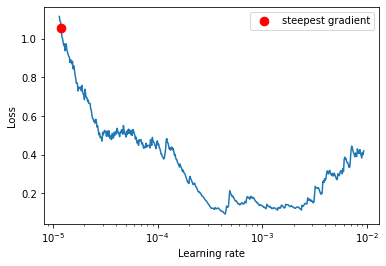

In [44]:
trainer.lr_find(train_dataloader, model_optimizer, start_lr=1e-5, end_lr=1e-2, num_iter=500)

## **7.1. Seq2seq GRU-based Unidirectional without Attention**

Best:
*   Training loss at epoch 22 - 0.016669148206710817
*   Valid loss at epoch 22 - 0.11058265723440112

To load the best checkpoint:

filename = encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_noatt_un_gru_30_15_new


In [ ]:
trainer.train(24, train_dataloader, test_dataloader, resume_only_model=True, resume=True)

Training loss at epoch 1 - 0.1184640856529586


{}
Valid loss at epoch 1 - 0.44408007665556304
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.0650108142127283


{}
Valid loss at epoch 2 - 0.2850622436677923
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.050987368245841935


{}
Valid loss at epoch 3 - 0.2484079895122927
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.04734996429004241


{}
Valid loss at epoch 4 - 0.21804426002259159
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.046373086400562896


{}
Valid loss at epoch 5 - 0.2260040872711308
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.045508330403827124


{}
Valid loss at epoch 6 - 0.22641669358221853
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.04412246760213748


{}
Valid loss at epoch 7 - 0.25516979198674766
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.042802763573417904


{}
Valid loss at epoch 8 - 0.2553459284256916
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.04049200256180484


{}
Valid loss at epoch 9 - 0.21999391997042966
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.03830879178713076


{}
Valid loss at epoch 10 - 0.2389389822373585
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.03672471451689489


{}
Valid loss at epoch 11 - 0.20209623493102133
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.03486830449954141


{}
Valid loss at epoch 12 - 0.1933927867865684
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.033561745281913316


{}
Valid loss at epoch 13 - 0.201401185054256
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.032847779048024675


{}
Valid loss at epoch 14 - 0.19194774531132106
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.02976705819455674


{}
Valid loss at epoch 15 - 0.17719815701854472
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.027655084902071393


{}
Valid loss at epoch 16 - 0.15892971489502458
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.025474400920793415


{}
Valid loss at epoch 17 - 0.14888822946849525
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.023297343832964543


{}
Valid loss at epoch 18 - 0.14445880177069684
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.021231748505379074


{}
Valid loss at epoch 19 - 0.13959138555338188
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.019206447843753267


{}
Valid loss at epoch 20 - 0.12044944330973893
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.017625985015183684


{}
Valid loss at epoch 21 - 0.11073827127716979
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.016669148206710817


{}
Valid loss at epoch 22 - 0.11058265723440112
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.01598797500220826


{}
Valid loss at epoch 23 - 0.12112187354692391
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.0154300491741742


{}
Valid loss at epoch 24 - 0.12380133102628954
saved checkpoint for epoch 24



## **7.2 Seq2seq GRU-based Unidirectional with Attention**

Best
*   Training loss at epoch 22 - 0.022565656618244247
*   Valid loss at epoch 22 - 0.1875706665331916

To load the best checkpoint:

filename = encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_att_un_gru_30_15_new



In [ ]:
trainer.train(24, train_dataloader, test_dataloader, resume_only_model=True, resume=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Training loss at epoch 1 - 0.13514157384517603


{}
Valid loss at epoch 1 - 0.5889436879328319
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.08633632396580651


{}
Valid loss at epoch 2 - 0.46702650219810254
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.0671519295827602


{}
Valid loss at epoch 3 - 0.3852532581255144
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.05972722347592935


{}
Valid loss at epoch 4 - 0.43727291489438136
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.055133635262318424


{}
Valid loss at epoch 5 - 0.4974583658028622
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.05562808116927044


{}
Valid loss at epoch 6 - 0.4412662710766403
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.0502968187633087


{}
Valid loss at epoch 7 - 0.3334648809110632
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.04740783963643481


{}
Valid loss at epoch 8 - 0.303039442215647
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.04434832827071659


{}
Valid loss at epoch 9 - 0.33817390823850824
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.04481741812604014


{}
Valid loss at epoch 10 - 0.34920611262929685
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.043041821847727986


{}
Valid loss at epoch 11 - 0.3676516855401652
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.04022674213512801


{}
Valid loss at epoch 12 - 0.3032518695963889
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.04031539089191938


{}
Valid loss at epoch 13 - 0.28897371796929106
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.04041754292760742


{}
Valid loss at epoch 14 - 0.25722882086981314
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.03897239413869102


{}
Valid loss at epoch 15 - 0.2342939957672236
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.03274896968185203


{}
Valid loss at epoch 16 - 0.20146808948139755
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.03155984272772912


{}
Valid loss at epoch 17 - 0.19636283275120112
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.029189672451902876


{}
Valid loss at epoch 18 - 0.19703854639463278
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.027458277110999917


{}
Valid loss at epoch 19 - 0.20790771778901013
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.025401351938489827


{}
Valid loss at epoch 20 - 0.2066603696201833
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.023684872472804274


{}
Valid loss at epoch 21 - 0.19390341768763503
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.022565656618244247


{}
Valid loss at epoch 22 - 0.1875706665331916
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.022191223760892175


{}
Valid loss at epoch 23 - 0.1922890722219433
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.021880265543441055


{}
Valid loss at epoch 24 - 0.19636425216283118
saved checkpoint for epoch 24



## **7.3. Seq2seq GRU-based Bidirectional without Attention**

Best:
*   Training loss at epoch 22 - 0.013258436144096778
*   Valid loss at epoch 22 - 0.10027954497431614

To load the best checkpoint:

filename = encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_noatt_bi_gru_30_15_new


In [ ]:
trainer.train(24, train_dataloader, test_dataloader, resume_only_model=True, resume=True)

Training loss at epoch 1 - 0.1292514012637548


{}
Valid loss at epoch 1 - 0.43478651740113083
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.07949257395695895


{}
Valid loss at epoch 2 - 0.3196996064970688
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.05450893251458183


{}
Valid loss at epoch 3 - 0.29420978150197435
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.04776412104838528


{}
Valid loss at epoch 4 - 0.2830512728922221
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.04574899616476614


{}
Valid loss at epoch 5 - 0.2698199279150184
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.04225520006031729


{}
Valid loss at epoch 6 - 0.26344107570392744
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.0397800794331124


{}
Valid loss at epoch 7 - 0.22472738615256183
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.037209047372743956


{}
Valid loss at epoch 8 - 0.22791374740856035
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.03469240768463351


{}
Valid loss at epoch 9 - 0.23979346644209357
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.03223020898993127


{}
Valid loss at epoch 10 - 0.18881620778417102
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.029982582461670973


{}
Valid loss at epoch 11 - 0.15465125000598479
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.026567931113531812


{}
Valid loss at epoch 12 - 0.19581345461156904
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.027667266135104


{}
Valid loss at epoch 13 - 0.1702551511021293
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.026926157700945624


{}
Valid loss at epoch 14 - 0.15053490026644906
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.025940052899823058


{}
Valid loss at epoch 15 - 0.116521770258111
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.02206034328672104


{}
Valid loss at epoch 16 - 0.10914175406250419
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.020220942593878136


{}
Valid loss at epoch 17 - 0.10319733365001726
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.01902104230655823


{}
Valid loss at epoch 18 - 0.11561714276215251
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.01697275374259334


{}
Valid loss at epoch 19 - 0.12076614640311015
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.015342256200965493


{}
Valid loss at epoch 20 - 0.10993761765029357
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.014030093647015745


{}
Valid loss at epoch 21 - 0.10313239961634485
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.013258436144096778


{}
Valid loss at epoch 22 - 0.10027954497431614
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.012699431681248825


{}
Valid loss at epoch 23 - 0.10658775828778744
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.012104900621634442


{}
Valid loss at epoch 24 - 0.11170923736478601
saved checkpoint for epoch 24



## **7.4. Seq2seq GRU-based Bidirectional with Attention**

Best:
*   Training loss at epoch 22 - 0.0085048594851105
*   Valid loss at epoch 22 - 0.10492954330936986

To load the best checkpoint:

filename = encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_att_bi_gru_30_15_new

In [ ]:
trainer.train(24, train_dataloader, test_dataloader, resume_only_model=True, resume=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Training loss at epoch 1 - 0.09602032503811643


{}
Valid loss at epoch 1 - 0.4713759785708116
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.07262756120879203


{}
Valid loss at epoch 2 - 0.3773644442613028
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.0586818190314807


{}
Valid loss at epoch 3 - 0.4782648769264318
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.05392803280759836


{}
Valid loss at epoch 4 - 0.33709106168576647
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.04589350478549022


{}
Valid loss at epoch 5 - 0.4394807692389099
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.03799226696835831


{}
Valid loss at epoch 6 - 0.462898708727895
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.03495644362643361


{}
Valid loss at epoch 7 - 0.3122839415255858
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.029907368793501518


{}
Valid loss at epoch 8 - 0.3944763893983802
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.028322387352236546


{}
Valid loss at epoch 9 - 0.3831177326489468
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.03153842892235844


{}
Valid loss at epoch 10 - 0.3036187522265376
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.02365927996812388


{}
Valid loss at epoch 11 - 0.2950266988909974
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.027146994862123394


{}
Valid loss at epoch 12 - 0.18275961804450774
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.025581475173530634


{}
Valid loss at epoch 13 - 0.1444437548100036
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.021951870844641234


{}
Valid loss at epoch 14 - 0.1612645185799623
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.01954302241705591


{}
Valid loss at epoch 15 - 0.12515485967148324
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.01686494601519371


{}
Valid loss at epoch 16 - 0.11513326642084487
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.015670035738003206


{}
Valid loss at epoch 17 - 0.11012726218192553
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.013680980532226385


{}
Valid loss at epoch 18 - 0.12012972851873052
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.012598561414342839


{}
Valid loss at epoch 19 - 0.12194903900048562
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.010866404445987429


{}
Valid loss at epoch 20 - 0.11616309000445264
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.009561730058048853


{}
Valid loss at epoch 21 - 0.1088129915677163
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.0085048594851105


{}
Valid loss at epoch 22 - 0.10492954330936986
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.00791947134406655


{}
Valid loss at epoch 23 - 0.11211190631194991
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.007577051723637851


{}
Valid loss at epoch 24 - 0.11800431473446744
saved checkpoint for epoch 24



## **7.5. Seq2seq LSTM-based Unidirectional without Attention**

Best:
*   Training loss at epoch 22 - 0.02043259288329864
*   Valid loss at epoch 22 - 0.1011127873266838

To load the best checkpoint:

filename = encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_noatt_un_lstm_30_15_new

In [ ]:
trainer.train(24, train_dataloader, test_dataloader, resume_only_model=True, resume=True)

Training loss at epoch 1 - 0.13347763084806502


{}
Valid loss at epoch 1 - 0.47588508895465303
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.07719314996618777


{}
Valid loss at epoch 2 - 0.3504828169789849
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.058380297987023363


{}
Valid loss at epoch 3 - 0.28074237993177104
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.05089801916910801


{}
Valid loss at epoch 4 - 0.25371720337746095
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.04813649306597653


{}
Valid loss at epoch 5 - 0.21050613605398305
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.045500161749077964


{}
Valid loss at epoch 6 - 0.18182580644378857
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.04506668249552604


{}
Valid loss at epoch 7 - 0.20129237840978467
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.04321915340726264


{}
Valid loss at epoch 8 - 0.19106926594157608
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.04114675913209794


{}
Valid loss at epoch 9 - 0.193354921377435
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.039252908483322246


{}
Valid loss at epoch 10 - 0.22199922746845654
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.037521327736612875


{}
Valid loss at epoch 11 - 0.20297959895462406
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.03678458539681742


{}
Valid loss at epoch 12 - 0.18940921979291098
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.0348505143186776


{}
Valid loss at epoch 13 - 0.146735656056173
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.032883247009594926


{}
Valid loss at epoch 14 - 0.15284143737992462
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.03159791755810147


{}
Valid loss at epoch 15 - 0.13326712150354775
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.030177280174393674


{}
Valid loss at epoch 16 - 0.12038326523817923
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.0282465456466889


{}
Valid loss at epoch 17 - 0.1172552980406552
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.026470956580596974


{}
Valid loss at epoch 18 - 0.12047104206772483
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.024507430404482874


{}
Valid loss at epoch 19 - 0.1118784588286463
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.022686033672653136


{}
Valid loss at epoch 20 - 0.10822067029622136
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.021545846709632315


{}
Valid loss at epoch 21 - 0.10318448624516628
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.02043259288329864


{}
Valid loss at epoch 22 - 0.1011127873266838
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.01964756826433586


{}
Valid loss at epoch 23 - 0.10566306634977156
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.019166374190244823


{}
Valid loss at epoch 24 - 0.10642545430787972
saved checkpoint for epoch 24



## **7.6. Seq2seq LSTM-based Unidirectional with Attention**

Best:
*   Training loss at epoch 22 - 0.030514359332155436
*   Valid loss at epoch 22 - 0.21590641673122132

To load the best checkpoint:

filename = encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_att_un_lstm_30_15_new


In [29]:
trainer.train(24, train_dataloader, test_dataloader, resume_only_model=True, resume=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Training loss at epoch 1 - 0.1621143136161845


{}
Valid loss at epoch 1 - 0.6116364631725817
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.09540338326827624


{}
Valid loss at epoch 2 - 0.41867564291674264
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.07986594585585408


{}
Valid loss at epoch 3 - 0.36137731920699684
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.07397367280849722


{}
Valid loss at epoch 4 - 0.34975879745823996
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.07230129791889339


{}
Valid loss at epoch 5 - 0.4901445771054346
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.06691221152839717


{}
Valid loss at epoch 6 - 0.344514380570273
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.0630515368160559


{}
Valid loss at epoch 7 - 0.5378949833767754
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.06298921957088169


{}
Valid loss at epoch 8 - 0.5100341211168133
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.057277344142203215


{}
Valid loss at epoch 9 - 0.44801071149354077
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.052797101664182264


{}
Valid loss at epoch 10 - 0.4326351576161628
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.050005797994090245


{}
Valid loss at epoch 11 - 0.35918483168494947
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.049638385416474196


{}
Valid loss at epoch 12 - 0.2809709004905759
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.04928542199471849


{}
Valid loss at epoch 13 - 0.2625839259779575
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.0481255410448648


{}
Valid loss at epoch 14 - 0.352548533860518
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.047556131146266126


{}
Valid loss at epoch 15 - 0.2560582456502075
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.04438708616537042


{}
Valid loss at epoch 16 - 0.234413422796191
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.04106135612702928


{}
Valid loss at epoch 17 - 0.22722713293849814
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.037404917005333126


{}
Valid loss at epoch 18 - 0.2276808277190644
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.03481401580065721


{}
Valid loss at epoch 19 - 0.2301110824836152
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.03288628950700513


{}
Valid loss at epoch 20 - 0.2306171984088664
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.031377316811122


{}
Valid loss at epoch 21 - 0.21971126978418656
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.030514359332155436


{}
Valid loss at epoch 22 - 0.21590641673122132
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.029734155801415908


{}
Valid loss at epoch 23 - 0.22380055382619707
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.029298311094316888


{}
Valid loss at epoch 24 - 0.2291207474523357
saved checkpoint for epoch 24



## **7.7. Seq2seq LSTM-based Bidirectional without Attention**

Best:
*   Training loss at epoch 22 - 0.0184628657400026
*   Valid loss at epoch 22 - 0.09356129038318688

To load the best checkpoint:

filename = encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_noatt_bi_lstm_30_15_new

In [45]:
trainer.train(24, train_dataloader, test_dataloader, resume_only_model=True, resume=True)

Training loss at epoch 1 - 0.18367320098914205


{}
Valid loss at epoch 1 - 0.3829776627980933
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.10208180819172412


{}
Valid loss at epoch 2 - 0.2884753947051204
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.07057483502663671


{}
Valid loss at epoch 3 - 0.22975377426767835
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.056084907812764866


{}
Valid loss at epoch 4 - 0.19995309058956953
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.04914543367514852


{}
Valid loss at epoch 5 - 0.17085878298218762
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.04442532667715568


{}
Valid loss at epoch 6 - 0.18858953295465636
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.04199763247335796


{}
Valid loss at epoch 7 - 0.1950321671153818
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.040357718031737023


{}
Valid loss at epoch 8 - 0.22504281876038532
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.038845617214392406


{}
Valid loss at epoch 9 - 0.20561141429507002
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.036357738764781974


{}
Valid loss at epoch 10 - 0.1713064031637445
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.034751814463816116


{}
Valid loss at epoch 11 - 0.15621977922867755
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.033674078546464446


{}
Valid loss at epoch 12 - 0.17749260217711635
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.033257029939559285


{}
Valid loss at epoch 13 - 0.11675261322180835
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.030446613561362027


{}
Valid loss at epoch 14 - 0.12894392585647957
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.029196568523184398


{}
Valid loss at epoch 15 - 0.10702863221569937
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.027794737573130987


{}
Valid loss at epoch 16 - 0.12058497507277192
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.026261463770933916


{}
Valid loss at epoch 17 - 0.1183488611702104
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.02390772581915371


{}
Valid loss at epoch 18 - 0.11719104860510145
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.02208187686803285


{}
Valid loss at epoch 19 - 0.11215107135322629
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.020487056860001757


{}
Valid loss at epoch 20 - 0.10287939274341476
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.019347171092522333


{}
Valid loss at epoch 21 - 0.09447826504023099
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.0184628657400026


{}
Valid loss at epoch 22 - 0.09356129038318688
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.017575087981531394


{}
Valid loss at epoch 23 - 0.0995028702808278
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.01711583573487587


{}
Valid loss at epoch 24 - 0.10140124655195645
saved checkpoint for epoch 24



## **7.8. Seq2seq LSTM-based Bidirectional with Attention**

Best:
*   Training loss at epoch 22 - 0.019473949636449106
*   Valid loss at epoch 22 - 0.2079560047737798

To load the best checkpoint:

filename = encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_att_bi_lstm_30_15_new


In [37]:
trainer.train(24, train_dataloader, test_dataloader, resume_only_model=True, resume=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Training loss at epoch 1 - 0.15186287010088562


{}
Valid loss at epoch 1 - 0.6860375659806388
saved checkpoint for epoch 1


Training loss at epoch 2 - 0.08482489719288423


{}
Valid loss at epoch 2 - 0.41301919398259146
saved checkpoint for epoch 2


Training loss at epoch 3 - 0.0754552585395868


{}
Valid loss at epoch 3 - 0.4115747547119248
saved checkpoint for epoch 3


Training loss at epoch 4 - 0.0703328270703787


{}
Valid loss at epoch 4 - 0.5009627257074628
saved checkpoint for epoch 4


Training loss at epoch 5 - 0.067066479891364


{}
Valid loss at epoch 5 - 0.4177051190362901
saved checkpoint for epoch 5


Training loss at epoch 6 - 0.06493384558707475


{}
Valid loss at epoch 6 - 0.510939181155088
saved checkpoint for epoch 6


Training loss at epoch 7 - 0.06008111665258184


{}
Valid loss at epoch 7 - 0.3451823971557374
saved checkpoint for epoch 7


Training loss at epoch 8 - 0.055847049762960524


{}
Valid loss at epoch 8 - 0.4262861881633194
saved checkpoint for epoch 8


Training loss at epoch 9 - 0.05095784432720393


{}
Valid loss at epoch 9 - 0.35530465423148505
saved checkpoint for epoch 9


Training loss at epoch 10 - 0.04751464444561861


{}
Valid loss at epoch 10 - 0.3585308597100024
saved checkpoint for epoch 10


Training loss at epoch 11 - 0.04796412881391006


{}
Valid loss at epoch 11 - 0.33811232538855807
saved checkpoint for epoch 11


Training loss at epoch 12 - 0.05268508514491259


{}
Valid loss at epoch 12 - 0.3241362237200445
saved checkpoint for epoch 12


Training loss at epoch 13 - 0.046071725446236084


{}
Valid loss at epoch 13 - 0.39871593838443564
saved checkpoint for epoch 13


Training loss at epoch 14 - 0.04408061539463233


{}
Valid loss at epoch 14 - 0.2469140580494185
saved checkpoint for epoch 14


Training loss at epoch 15 - 0.03986014842026634


{}
Valid loss at epoch 15 - 0.2361180392303029
saved checkpoint for epoch 15


Training loss at epoch 16 - 0.03718809212296037


{}
Valid loss at epoch 16 - 0.22961942315557782
saved checkpoint for epoch 16


Training loss at epoch 17 - 0.032350732939667066


{}
Valid loss at epoch 17 - 0.2132642617145059
saved checkpoint for epoch 17


Training loss at epoch 18 - 0.027528102771902922


{}
Valid loss at epoch 18 - 0.23235670414430146
saved checkpoint for epoch 18


Training loss at epoch 19 - 0.02539253654103959


{}
Valid loss at epoch 19 - 0.2335063125177914
saved checkpoint for epoch 19


Training loss at epoch 20 - 0.02246169077712693


{}
Valid loss at epoch 20 - 0.2214982686754392
saved checkpoint for epoch 20


Training loss at epoch 21 - 0.020948938648944024


{}
Valid loss at epoch 21 - 0.21024363027999596
saved checkpoint for epoch 21


Training loss at epoch 22 - 0.019473949636449106


{}
Valid loss at epoch 22 - 0.2079560047737798
saved checkpoint for epoch 22


Training loss at epoch 23 - 0.01862921831343556


{}
Valid loss at epoch 23 - 0.2158332909172287
saved checkpoint for epoch 23


Training loss at epoch 24 - 0.018144285280868644


{}
Valid loss at epoch 24 - 0.21845806215186508
saved checkpoint for epoch 24



# **8. Inference**

In [ ]:
# trainer._load_checkpoint(only_model=True, name='checkpoint_9')

loaded checkpoint for epoch - 12


12

In [46]:
trainer._load_best_checkpoint()

loaded checkpoint for epoch - 22


In [47]:
test_predictions = trainer.predict(test_dataloader)

In [48]:
test.head()

COUNTRY  ... yearly_corr
335  Afghanistan  ...   -0.717773
336  Afghanistan  ...   -0.717773
337  Afghanistan  ...   -0.717773
338  Afghanistan  ...   -0.717773
339  Afghanistan  ...   -0.717773

[5 rows x 5 columns]

In [49]:
test.index = range(len(test))

In [50]:
test['predictions'] = pd.Series(test_predictions.tolist())

In [51]:
test['X'] = test['x_sequence'].apply(lambda x: x[:, 0])
test['Y'] = test['y_sequence'].apply(lambda x: x[:, 0])

# **9. Rescale data**

In [52]:
def rescale_data(scale_map, data_df, columns=['predictions', 'y_sequence', 'x_sequence']):
    rescaled_data = pd.DataFrame()
    for country_id, item_data in tqdm(data_df.groupby('COUNTRY', as_index=False)):
        if country_id == '#NA#':
          continue
        mu = scale_map[country_id]['mu']
        sigma = scale_map[country_id]['sigma']
        for col in columns:
            item_data[col] = item_data[col].apply(lambda x: (np.array(x) * sigma) + mu)
        rescaled_data = pd.concat([rescaled_data, item_data], ignore_index=True)
    return rescaled_data

In [ ]:
scale_map

{'Afghanistan': {'mu': 34064.95399515738, 'sigma': 19676.471944922818},
 'Albania': {'mu': 33028.28431372549, 'sigma': 40556.611212287185},
 'Algeria': {'mu': 29060.918417799752, 'sigma': 38798.47200004003},
 'Angola': {'mu': 8792.082474226803, 'sigma': 8629.03241876727},
 'Antigua and Barbuda': {'mu': 210.11414392059552,
  'sigma': 304.74823125195167},
 'Argentina': {'mu': 894262.7814070352, 'sigma': 840311.4295227897},
 'Armenia': {'mu': 74779.34651162791, 'sigma': 69611.35747658422},
 'Australia': {'mu': 18470.218894009216, 'sigma': 11199.52578303688},
 'Austria': {'mu': 170825.4411027569, 'sigma': 191289.52530184962},
 'Azerbaijan': {'mu': 91007.95577395578, 'sigma': 97107.28613403958},
 'Bahamas': {'mu': 4136.598984771574, 'sigma': 3655.5147236411512},
 'Bahrain': {'mu': 60576.90510948905, 'sigma': 44956.78046565741},
 'Bangladesh': {'mu': 312546.55, 'sigma': 210216.53188403317},
 'Barbados': {'mu': 712.8069306930693, 'sigma': 1122.8819984677211},
 'Belarus': {'mu': 110707.9769053

In [ ]:
'#NA#' in test.COUNTRY.unique()

False

In [72]:
test_rescaled = rescale_data(scale_map, test, columns=['X', 'Y', 'predictions'])

In [73]:
test = test_rescaled

# **10. Result Analysis**

In [74]:
test.head()

COUNTRY  ...                                                  Y
0  Afghanistan  ...  [55643.742, 55662.957, 55682.17, 55701.387, 55...
1  Afghanistan  ...  [55662.957, 55682.17, 55701.387, 55701.387, 55...
2  Afghanistan  ...  [55682.17, 55701.387, 55701.387, 55720.6, 5573...
3  Afghanistan  ...  [55701.387, 55701.387, 55720.6, 55739.82, 5575...
4  Afghanistan  ...  [55701.387, 55720.6, 55739.82, 55759.03, 55778...

[5 rows x 8 columns]

In [75]:
def plot_sequence_row(row, in_range=n_in, out_range=n_out):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(in_range)), y=row['X'],
                        mode='lines',
                        name='past data'))
    fig.add_trace(go.Scatter(x=list(range(in_range, in_range + out_range)), y=row['Y'],
                        mode='lines',
                        name='actual'))
    fig.add_trace(go.Scatter(x=list(range(in_range, in_range + out_range)), y=row['predictions'],
                        mode='lines',
                        name='predictions'))
    fig.show()

In [76]:
test['predictions'] = test['predictions'].apply(np.array)

In [77]:
def get_col_mean(group_data):
    agg_data = {}
    for col in group_data.columns:
        if col == 'ObservationDate':
            continue
        agg_data[col] = group_data[col].mean()
    return pd.Series(agg_data)

In [78]:
date_predictions = test[['X', 'Y', 'predictions', 'ObservationDate']].groupby('ObservationDate').apply(get_col_mean)

In [79]:
plot_sequence_row(date_predictions.iloc[-1])

# **11. Results**

In [83]:
def generate_flat_df(sequence_data, predict_col='predictions', actual_col='Y'):
    flat_df = pd.DataFrame()
    for i, row in sequence_data.iterrows():
        row_df = pd.DataFrame()
        start_date = row['ObservationDate']
        row_df['ObservationDate'] = pd.date_range(start_date, periods=n_out).date.tolist()
        row_df['COUNTRY'] = row['COUNTRY']
        row_df['MEASURE'] = row['MEASURE']
        row_df['predictions'] = np.rint(row[predict_col])
        if actual_col:
            row_df['Confirmed'] = np.rint(np.around(row[actual_col]))
        flat_df = pd.concat([flat_df, row_df], ignore_index=False)
    flat_df.index = range(len(flat_df))
    flat_df['ObservationDate'] = pd.to_datetime(flat_df['ObservationDate'])
    return flat_df

In [84]:
test_sequence_data_sample = test[test['ObservationDate'] == '2021-02-23'] # after the train_split 2020-02-22 
test_with_MEASURE = test_with_MEASURE[test_with_MEASURE['ObservationDate'] == '2021-02-23']
test_sequence_data_sample['MEASURE'] = test_with_MEASURE['MEASURE'].tolist()
test_predict_df = generate_flat_df(test_sequence_data_sample)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [85]:
test_predict_df.head()

ObservationDate      COUNTRY  ... predictions  Confirmed
0      2021-02-23  Afghanistan  ...     59169.0    55644.0
1      2021-02-24  Afghanistan  ...     61837.0    55663.0
2      2021-02-25  Afghanistan  ...     62426.0    55682.0
3      2021-02-26  Afghanistan  ...     62544.0    55701.0
4      2021-02-27  Afghanistan  ...     62586.0    55701.0

[5 rows x 5 columns]

In [86]:
def smape(y_pred, y_true):
    print(len(y_true))
    print(len(y_pred))
    denominator = (y_true + y_pred) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [87]:
smape(test_predict_df['predictions'], test_predict_df['Confirmed'])

2730
2730


5.382155942806522

In [88]:
smape(np.round(test_predict_df['predictions']), test_predict_df['Confirmed'])

2730
2730


5.382155942806522